### Correlation Based Probability Adjustments
#### Daniel Fay

In [1]:
# Import necessary packages
import pandas as pd
from pandas import DataFrame
import numpy as np
import pickle
import itertools
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import normalize
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import random
%matplotlib inline

ModuleNotFoundError: No module named 'plotly'

In [31]:
# Load Data
idap = pd.read_csv('processed_data/IDAP_processed.csv', index_col=0)

### Calculate Correlation Matrices

In [32]:
# Create empty correlation matrices for every per type pair
corr_matrices = {}
for combination in list(itertools.product(idap.PERTYPE.unique(), repeat=2)):
    corr_matrices['{0}_{1}'.format(combination[0], combination[1])] = \
    pd.DataFrame(index=['M', 'NM', 'H'], columns=['M', 'NM', 'H'])
    corr_matrices['{0}_{1}'.format(combination[0], combination[1])].fillna(0, inplace=True)

In [33]:
# Fill in correlation matrices
for ix, row in idap.iterrows():
    household = idap.loc[ix]
    for per_type, idaps in zip(list(itertools.combinations(household.PERTYPE, 2)), \
                             list(itertools.combinations(household.IDAP, 2))):
        if idaps == ('M', 'M'):
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[0,0] += 1
            
        elif idaps == ('M', 'NM'):
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[0,1] += 1
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[1,0] += 1
            
        elif idaps == ('M', 'H'):
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[0,2] += 1
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[2,0] += 1

        elif idaps == ('NM', 'M'):
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[1,0] += 1
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[0,1] += 1
            
        elif idaps == ('NM', 'NM'):
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[1,1] += 1
            
        elif idaps == ('NM', 'H'):
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[1,2] += 1
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[2,1] += 1
            
        elif idaps == ('H', 'M'):
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[2,0] += 1
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[0,2] += 1
            
        elif idaps == ('H', 'NM'):
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[2,1] += 1
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[1,2] += 1
            
        elif idaps == ('H', 'H'):
            corr_matrices['{0}_{1}'.format(per_type[0], per_type[1])].iloc[2,2] += 1

In [34]:
# Combine same correlation matrices
for combinations in list(itertools.combinations_with_replacement(idap.PERTYPE.unique(), 2)):
    corr_matrices['{0}_{1}'.format(combinations[0], combinations[1])] = corr_matrices['{0}_{1}'.format(combinations[0], combinations[1])] +\
                                                                        corr_matrices['{1}_{0}'.format(combinations[0], combinations[1])]
    corr_matrices['{1}_{0}'.format(combinations[0], combinations[1])] = corr_matrices['{0}_{1}'.format(combinations[0], combinations[1])]

In [35]:
# # Row Normalize correlation matrices
# for matrix in corr_matrices:
#     corr_matrices[matrix] = pd.DataFrame(normalize(corr_matrices[matrix], norm='l1', axis=1), index=['M', 'NM', 'H'], columns=['M', 'NM', 'H'])

In [36]:
# Symmetrical Normalize correlation matrices 
for combinations in list(itertools.product(idap.PERTYPE.unique(), repeat=2)):
    corr_matrices['{0}_{1}'.format(combinations[0], combinations[1])] = corr_matrices['{0}_{1}'.format(combinations[0], combinations[1])] \
                                                                        /sum(corr_matrices['{0}_{1}'.format(combinations[0], combinations[1])].sum(0))

In [37]:
# Output correlation matrix to csv
with open('processed_data/correlation_matrices.pkl', 'wb') as handle:
    pickle.dump(corr_matrices, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Find Most Frequent Activity Pattern for each Per Type

In [38]:
dap_count = idap.groupby(['PERTYPE', 'IDAP']).count()
dap_count.reset_index(inplace=True)
max_dap_pertype = pd.DataFrame()
for pertype in idap.PERTYPE.unique():
    df = dap_count[dap_count['PERTYPE'] == pertype]
    max_dap = pd.DataFrame([df.loc[df['PERNO'].argmax()]['PERTYPE'], df.loc[df['PERNO'].argmax()]['IDAP']])
    max_dap_pertype = max_dap_pertype.append(max_dap.T)
    
max_dap_pertype.columns = ['PERTYPE', 'MAX_IDAP']

In [39]:
max_dap_pertype

,PERTYPE,MAX_IDAP
0,Retiree,NM
0,FT_Worker,M
0,PT_Worker,M
0,DA_Stud,M
0,PreSch_Child,NM
0,PDA_Stud,M
0,Non_Worker,NM
0,Univ_Stud,M


### Define Correlation Adjustment Algorithm

In [40]:
def correlation_probability_adjustments(alpha):
    # 1st iteration
    adjusted_probs = []
    mandatory_pertypes = ['FT_Worker', 'PT_Worker', 'DA_Stud', 'PDA_Stud', 'Univ_Stud']
    nonmandatory_pertypes = ['Retiree', 'PreSch_Child', 'Non_Worker']
    for index in idap.index.unique():
        df = pd.DataFrame(idap.loc[index])
        if len(df.T) == 1:
            adjusted_probs.append([df.T['H'].values[0], df.T['M'].values[0], df.T['NM'].values[0]])
            pass
        else:
#             df['perno'] = random.sample(range(1,len(df)+1),len(df))
#             df.sort_values('perno', inplace=True)
            for idx, row in df.iterrows():
                if row['PERNO'] == 1:
                    prev_dap = row['PREDICTION']
                    prev_pertype = row['PERTYPE']
                    prev_prob = row[prev_dap]
                    adjusted_probs.append([row['H'], row['M'], row['NM']])
                else:
                    if row['PERTYPE'] in mandatory_pertypes:
                        joint_prob_M = 0.001
                        #joint_prob_M = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][0]
                        joint_prob_NM = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][1]
                        joint_prob_H = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][2]
                        prob_M = prev_prob * row['M'] * joint_prob_M**alpha
                        prob_NM = prev_prob * row['NM'] * joint_prob_NM**alpha
                        prob_H = prev_prob * row['H'] * joint_prob_H**alpha
                        prev_dap = row['PREDICTION']
                        prev_pertype = row['PERTYPE']
                        prev_prob = row[prev_dap]
                        norm = [float(i)/sum([prob_H, prob_M, prob_NM]) for i in [prob_H, prob_M, prob_NM]]
                        adjusted_probs.append(norm)
                    elif row['PERTYPE'] in nonmandatory_pertypes:
                        joint_prob_NM = 0.001
                        joint_prob_M = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][0]
                        #joint_prob_NM = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][1]
                        joint_prob_H = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][2]
                        prob_M = prev_prob * row['M'] * joint_prob_M**alpha
                        prob_NM = prev_prob * row['NM'] * joint_prob_NM**alpha
                        prob_H = prev_prob * row['H'] * joint_prob_H**alpha
                        prev_dap = row['PREDICTION']
                        prev_pertype = row['PERTYPE']
                        prev_prob = row[prev_dap]
                        norm = [float(i)/sum([prob_H, prob_M, prob_NM]) for i in [prob_H, prob_M, prob_NM]]
                        adjusted_probs.append(norm)
                        
    idap['H_ADJ'] = [i[0] for i in adjusted_probs]
    idap['M_ADJ'] = [i[1] for i in adjusted_probs]
    idap['NM_ADJ'] = [i[2] for i in adjusted_probs]
    
    adj_predictions = []
    for ix, row in idap.iterrows():
        if row['H_ADJ'] > row['M_ADJ'] and row['H_ADJ'] > row['NM_ADJ']:
            adj_predictions.append('H')
        elif row['M_ADJ'] > row['H_ADJ'] and row['M_ADJ'] > row['NM_ADJ']:
            adj_predictions.append('M')
        else:
            adj_predictions.append('NM')

    idap['PREDICTION_ADJ'] = adj_predictions
    
    # 2nd iteration
    adjusted_probs_2 = []               
    for index in idap.index.unique():
        df = pd.DataFrame(idap.loc[index])
        if len(df.T) == 1:
            adjusted_probs_2.append([df.T['H_ADJ'].values[0], df.T['M_ADJ'].values[0], df.T['NM_ADJ'].values[0]])
            pass
        else:
            prev_dap = df.tail(1)['PREDICTION_ADJ'].iloc[0]
            prev_pertype = df.tail(1)['PERTYPE'].iloc[0]
            prev_prob = df.tail(1)[prev_dap + '_ADJ'].iloc[0]
            for idx, row in df.iterrows():
                if row['PERTYPE'] in mandatory_pertypes:
                    joint_prob_M = 0.001
                    #joint_prob_M = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][0]
                    joint_prob_NM = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][1]
                    joint_prob_H = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][2]
                    prob_M = prev_prob * row['M'] * joint_prob_M**alpha
                    prob_NM = prev_prob * row['NM'] * joint_prob_NM**alpha
                    prob_H = prev_prob * row['H'] * joint_prob_H**alpha
                    prev_dap = row['PREDICTION_ADJ']
                    prev_pertype = row['PERTYPE']
                    prev_prob = row[prev_dap]
                    norm = [float(i)/sum([prob_H, prob_M, prob_NM]) for i in [prob_H, prob_M, prob_NM]]
                    adjusted_probs_2.append(norm)
                    
                elif row['PERTYPE'] in nonmandatory_pertypes:
                    joint_prob_M = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][0]
                    joint_prob_NM = 0.001
                    #joint_prob_NM = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][1]
                    joint_prob_H = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][2]
                    prob_M = prev_prob * row['M'] * joint_prob_M**alpha
                    prob_NM = prev_prob * row['NM'] * joint_prob_NM**alpha
                    prob_H = prev_prob * row['H'] * joint_prob_H**alpha
                    prev_dap = row['PREDICTION_ADJ']
                    prev_pertype = row['PERTYPE']
                    prev_prob = row[prev_dap]
                    norm = [float(i)/sum([prob_H, prob_M, prob_NM]) for i in [prob_H, prob_M, prob_NM]]
                    adjusted_probs_2.append(norm)
                    
    idap['H_ADJ_2'] = [i[0] for i in adjusted_probs_2]
    idap['M_ADJ_2'] = [i[1] for i in adjusted_probs_2]
    idap['NM_ADJ_2'] = [i[2] for i in adjusted_probs_2]

    adj_predictions_2 = []
    for ix, row in idap.iterrows():
        if row['H_ADJ_2'] > row['M_ADJ_2'] and row['H_ADJ_2'] > row['NM_ADJ_2']:
            adj_predictions_2.append('H')
        elif row['M_ADJ_2'] > row['H_ADJ_2'] and row['M_ADJ_2'] > row['NM_ADJ_2']:
            adj_predictions_2.append('M')
        else:
            adj_predictions_2.append('NM')

    idap['PREDICTION_ADJ_2'] = adj_predictions_2
    
    # 3rd iteration
    adjusted_probs_3 = []               
    for index in idap.index.unique():
        df = pd.DataFrame(idap.loc[index])
        if len(df.T) == 1:
            adjusted_probs_3.append([df.T['H_ADJ_2'].values[0], df.T['M_ADJ_2'].values[0], df.T['NM_ADJ_2'].values[0]])
            pass
        else:
            prev_dap = df.tail(1)['PREDICTION_ADJ_2'].iloc[0]
            prev_pertype = df.tail(1)['PERTYPE'].iloc[0]
            prev_prob = df.tail(1)[prev_dap + '_ADJ_2'].iloc[0]
            for idx, row in df.iterrows():
                if row['PERTYPE'] in mandatory_pertypes:
                    joint_prob_M = 0.001
                    #joint_prob_M = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][0]
                    joint_prob_NM = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][1]
                    joint_prob_H = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][2]
                    prob_M = prev_prob * row['M'] * joint_prob_M**alpha
                    prob_NM = prev_prob * row['NM'] * joint_prob_NM**alpha
                    prob_H = prev_prob * row['H'] * joint_prob_H**alpha
                    prev_dap = row['PREDICTION_ADJ_2']
                    prev_pertype = row['PERTYPE']
                    prev_prob = row[prev_dap]
                    norm = [float(i)/sum([prob_H, prob_M, prob_NM]) for i in [prob_H, prob_M, prob_NM]]
                    adjusted_probs_3.append(norm)
                    
                elif row['PERTYPE'] in nonmandatory_pertypes:
                    joint_prob_M = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][0]
                    joint_prob_NM = 0.001
                    #joint_prob_NM = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][1]
                    joint_prob_H = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][2]
                    prob_M = prev_prob * row['M'] * joint_prob_M**alpha
                    prob_NM = prev_prob * row['NM'] * joint_prob_NM**alpha
                    prob_H = prev_prob * row['H'] * joint_prob_H**alpha
                    prev_dap = row['PREDICTION_ADJ_2']
                    prev_pertype = row['PERTYPE']
                    prev_prob = row[prev_dap]
                    norm = [float(i)/sum([prob_H, prob_M, prob_NM]) for i in [prob_H, prob_M, prob_NM]]
                    adjusted_probs_3.append(norm)
                    
    idap['H_ADJ_3'] = [i[0] for i in adjusted_probs_3]
    idap['M_ADJ_3'] = [i[1] for i in adjusted_probs_3]
    idap['NM_ADJ_3'] = [i[2] for i in adjusted_probs_3]

    adj_predictions_3 = []
    for ix, row in idap.iterrows():
        if row['H_ADJ_3'] > row['M_ADJ_3'] and row['H_ADJ_3'] > row['NM_ADJ_3']:
            adj_predictions_3.append('H')
        elif row['M_ADJ_3'] > row['H_ADJ_3'] and row['M_ADJ_3'] > row['NM_ADJ_3']:
            adj_predictions_3.append('M')
        else:
            adj_predictions_3.append('NM')

    idap['PREDICTION_ADJ_3'] = adj_predictions_3
    
  # 4th iteration
    adjusted_probs_4 = []               
    for index in idap.index.unique():
        df = pd.DataFrame(idap.loc[index])
        if len(df.T) == 1:
            adjusted_probs_4.append([df.T['H_ADJ_3'].values[0], df.T['M_ADJ_3'].values[0], df.T['NM_ADJ_3'].values[0]])
            pass
        else:
            prev_dap = df.tail(1)['PREDICTION_ADJ_3'].iloc[0]
            prev_pertype = df.tail(1)['PERTYPE'].iloc[0]
            prev_prob = df.tail(1)[prev_dap + '_ADJ_3'].iloc[0]
            for idx, row in df.iterrows():
                if row['PERTYPE'] in mandatory_pertypes:
                    joint_prob_M = 0.001
                    #joint_prob_M = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][0]
                    joint_prob_NM = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][1]
                    joint_prob_H = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][2]
                    prob_M = prev_prob * row['M'] * joint_prob_M**alpha
                    prob_NM = prev_prob * row['NM'] * joint_prob_NM**alpha
                    prob_H = prev_prob * row['H'] * joint_prob_H**alpha
                    prev_dap = row['PREDICTION_ADJ_3']
                    prev_pertype = row['PERTYPE']
                    prev_prob = row[prev_dap]
                    norm = [float(i)/sum([prob_H, prob_M, prob_NM]) for i in [prob_H, prob_M, prob_NM]]
                    adjusted_probs_4.append(norm)
                    
                elif row['PERTYPE'] in nonmandatory_pertypes:
                    joint_prob_M = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][0]
                    joint_prob_NM = 0.001
                    #joint_prob_NM = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][1]
                    joint_prob_H = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][2]
                    prob_M = prev_prob * row['M'] * joint_prob_M**alpha
                    prob_NM = prev_prob * row['NM'] * joint_prob_NM**alpha
                    prob_H = prev_prob * row['H'] * joint_prob_H**alpha
                    prev_dap = row['PREDICTION_ADJ_3']
                    prev_pertype = row['PERTYPE']
                    prev_prob = row[prev_dap]
                    norm = [float(i)/sum([prob_H, prob_M, prob_NM]) for i in [prob_H, prob_M, prob_NM]]
                    adjusted_probs_4.append(norm)
                    
    idap['H_ADJ_4'] = [i[0] for i in adjusted_probs_4]
    idap['M_ADJ_4'] = [i[1] for i in adjusted_probs_4]
    idap['NM_ADJ_4'] = [i[2] for i in adjusted_probs_4]

    adj_predictions_4 = []
    for ix, row in idap.iterrows():
        if row['H_ADJ_4'] > row['M_ADJ_4'] and row['H_ADJ_4'] > row['NM_ADJ_4']:
            adj_predictions_4.append('H')
        elif row['M_ADJ_4'] > row['H_ADJ_4'] and row['M_ADJ_4'] > row['NM_ADJ_4']:
            adj_predictions_4.append('M')
        else:
            adj_predictions_4.append('NM')

    idap['PREDICTION_ADJ_4'] = adj_predictions_4
    
  # 5th iteration
    adjusted_probs_5 = []               
    for index in idap.index.unique():
        df = pd.DataFrame(idap.loc[index])
        if len(df.T) == 1:
            adjusted_probs_5.append([df.T['H_ADJ_4'].values[0], df.T['M_ADJ_4'].values[0], df.T['NM_ADJ_4'].values[0]])
            pass
        else:
            prev_dap = df.tail(1)['PREDICTION_ADJ_4'].iloc[0]
            prev_pertype = df.tail(1)['PERTYPE'].iloc[0]
            prev_prob = df.tail(1)[prev_dap + '_ADJ_4'].iloc[0]
            for idx, row in df.iterrows():
                if row['PERTYPE'] in mandatory_pertypes:
                    joint_prob_M = 0.001
                    #joint_prob_M = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][0]
                    joint_prob_NM = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][1]
                    joint_prob_H = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][2]
                    prob_M = prev_prob * row['M'] * joint_prob_M**alpha
                    prob_NM = prev_prob * row['NM'] * joint_prob_NM**alpha
                    prob_H = prev_prob * row['H'] * joint_prob_H**alpha
                    prev_dap = row['PREDICTION_ADJ_4']
                    prev_pertype = row['PERTYPE']
                    prev_prob = row[prev_dap]
                    norm = [float(i)/sum([prob_H, prob_M, prob_NM]) for i in [prob_H, prob_M, prob_NM]]
                    adjusted_probs_5.append(norm)
                    
                elif row['PERTYPE'] in nonmandatory_pertypes:
                    joint_prob_M = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][0]
                    joint_prob_NM = 0.001
                    #joint_prob_NM = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][1]
                    joint_prob_H = corr_matrices['{0}_{1}'.format(prev_pertype, row['PERTYPE'])][prev_dap][2]
                    prob_M = prev_prob * row['M'] * joint_prob_M**alpha
                    prob_NM = prev_prob * row['NM'] * joint_prob_NM**alpha
                    prob_H = prev_prob * row['H'] * joint_prob_H**alpha
                    prev_dap = row['PREDICTION_ADJ_4']
                    prev_pertype = row['PERTYPE']
                    prev_prob = row[prev_dap]
                    norm = [float(i)/sum([prob_H, prob_M, prob_NM]) for i in [prob_H, prob_M, prob_NM]]
                    adjusted_probs_5.append(norm)
                    
    idap['H_ADJ_5'] = [i[0] for i in adjusted_probs_5]
    idap['M_ADJ_5'] = [i[1] for i in adjusted_probs_5]
    idap['NM_ADJ_5'] = [i[2] for i in adjusted_probs_5]

    adj_predictions_5 = []
    for ix, row in idap.iterrows():
        if row['H_ADJ_5'] > row['M_ADJ_5'] and row['H_ADJ_5'] > row['NM_ADJ_5']:
            adj_predictions_5.append('H')
        elif row['M_ADJ_5'] > row['H_ADJ_5'] and row['M_ADJ_5'] > row['NM_ADJ_5']:
            adj_predictions_5.append('M')
        else:
            adj_predictions_5.append('NM')

    idap['PREDICTION_ADJ_5'] = adj_predictions_5

In [142]:
# Tune Alpha Parameter
alphas = np.arange(0.1,1,.05)
f1 = []
prob_results = pd.DataFrame()

for alpha in alphas:
    correlation_probability_adjustments(alpha)
    f1.append(f1_score(idap['IDAP'], idap['PREDICTION_ADJ_3'], average='weighted')*100)
    
results = [f1, alphas]
max_index = results[0].index(max(results[0]))

C:\Users\fayd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\fayd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:123: RuntimeWarning:

invalid value encountered in double_scalars



Text(0.75,0.5,'Optimal Alpha: 0.10')

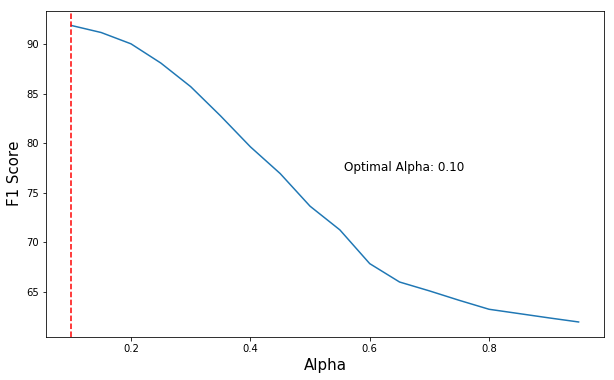

In [143]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.plot(alphas, f1)
plt.xlabel('Alpha', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.axvline(results[1][max_index], color='r', linestyle='--')
plt.text(.75, .5, 'Optimal Alpha: {0:.2f}'.format(results[1][max_index]), verticalalignment='bottom', transform=ax.transAxes, \
        horizontalalignment='right', fontsize=12)

In [41]:
correlation_probability_adjustments(.10)

C:\Users\fayd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\fayd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:155: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\fayd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:196: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\fayd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:251: RuntimeWarning:

invalid value encountered in double_scalars



In [42]:
dap_changes = pd.DataFrame()
total = len(idap)

counter = 0
for ix, row in idap.iterrows():
    if row['PREDICTION'] != row['PREDICTION_ADJ']:
        counter += 1
dap_changes = dap_changes.append(pd.DataFrame(['Initial to Adj 1', counter/total]).T)

counter = 0
for ix, row in idap.iterrows():
    if row['PREDICTION_ADJ'] != row['PREDICTION_ADJ_2']:
        counter += 1
dap_changes = dap_changes.append(pd.DataFrame(['Adj 1 to Adj 2', counter/total]).T)

counter = 0
for ix, row in idap.iterrows():
    if row['PREDICTION_ADJ_2'] != row['PREDICTION_ADJ_3']:
        counter += 1
dap_changes = dap_changes.append(pd.DataFrame(['Adj 2 to Adj 3', counter/total]).T)

counter = 0
for ix, row in idap.iterrows():
    if row['PREDICTION_ADJ_3'] != row['PREDICTION_ADJ_4']:
        counter += 1
dap_changes = dap_changes.append(pd.DataFrame(['Adj 3 to Adj 4', counter/total]).T)

counter = 0
for ix, row in idap.iterrows():
    if row['PREDICTION_ADJ_4'] != row['PREDICTION_ADJ_5']:
        counter += 1
dap_changes = dap_changes.append(pd.DataFrame(['Adj 4 to Adj 5', counter/total]).T)

dap_changes.columns = ['Phase', 'Change Count']
dap_changes.reset_index(inplace=True)
init_notebook_mode(connected=True)
trace1 = go.Bar(
            x=dap_changes['Phase'],
            y=dap_changes['Change Count']
) 

data = [trace1]
layout = go.Layout(
    title='Percentage of Changed Daily Activity Patterns'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

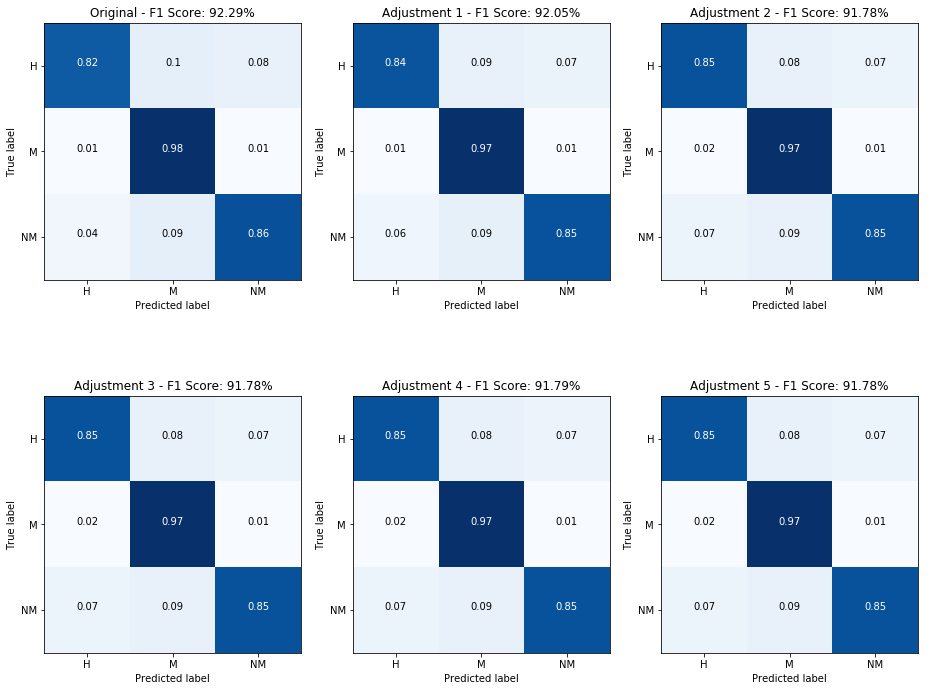

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13,13))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()
cmap = plt.cm.Blues
classes = ['H', 'M', 'NM']
cm1 = confusion_matrix(idap['IDAP'], idap['PREDICTION'])
cm2 = confusion_matrix(idap['IDAP'], idap['PREDICTION_ADJ'])
cm3 = confusion_matrix(idap['IDAP'], idap['PREDICTION_ADJ_2'])
cm4 = confusion_matrix(idap['IDAP'], idap['PREDICTION_ADJ_3'])
cm5 = confusion_matrix(idap['IDAP'], idap['PREDICTION_ADJ_4'])
cm6 = confusion_matrix(idap['IDAP'], idap['PREDICTION_ADJ_5'])
cms = [cm1, cm2, cm3, cm4, cm5, cm6]
axes = [ax0, ax1, ax2, ax3, ax4, ax5]
names = ['Original', 'Adjustment 1', 'Adjustment 2', 'Adjustment 3', 'Adjustment 4', 'Adjustment 5']
predictions = [idap['PREDICTION'], idap['PREDICTION_ADJ'], idap['PREDICTION_ADJ_2'], \
               idap['PREDICTION_ADJ_3'], idap['PREDICTION_ADJ_4'], idap['PREDICTION_ADJ_5']]

for ax, cm, name, prediction in zip(axes, cms, names, predictions):
    np.set_printoptions(precision=2)

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(name + ' - {0}'.format("F1 Score: {0:.4g}%".format(f1_score(idap['IDAP'], prediction, average='weighted')*100)))
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


In [188]:
prediction_adj_count_raw = idap.groupby(['PERTYPE', 'PREDICTION']).count()
prediction_adj_count_raw.reset_index(inplace=True)
prediction_adj_count_raw = prediction_adj_count_raw[['PERTYPE', 'PREDICTION', 'PERNO']]
prediction_adj_count_raw.columns = ['PERTYPE', 'PREDICTION', 'COUNT']

prediction_adj_count = idap.groupby(['PERTYPE', 'PREDICTION_ADJ']).count()
prediction_adj_count.reset_index(inplace=True)
prediction_adj_count = prediction_adj_count[['PERTYPE', 'PREDICTION_ADJ', 'PERNO']]
prediction_adj_count.columns = ['PERTYPE', 'PREDICTION_ADJ', 'COUNT']

prediction_adj_count_2 = idap.groupby(['PERTYPE', 'PREDICTION_ADJ_2']).count()
prediction_adj_count_2.reset_index(inplace=True)
prediction_adj_count_2 = prediction_adj_count_2[['PERTYPE', 'PREDICTION_ADJ_2', 'PERNO']]
prediction_adj_count_2.columns = ['PERTYPE', 'PREDICTION_ADJ_2', 'COUNT']

prediction_adj_count_3 = idap.groupby(['PERTYPE', 'PREDICTION_ADJ_3']).count()
prediction_adj_count_3.reset_index(inplace=True)
prediction_adj_count_3 = prediction_adj_count_3[['PERTYPE', 'PREDICTION_ADJ_3', 'PERNO']]
prediction_adj_count_3.columns = ['PERTYPE', 'PREDICTION_ADJ_3', 'COUNT']

prediction_adj_count_4 = idap.groupby(['PERTYPE', 'PREDICTION_ADJ_4']).count()
prediction_adj_count_4.reset_index(inplace=True)
prediction_adj_count_4 = prediction_adj_count_4[['PERTYPE', 'PREDICTION_ADJ_4', 'PERNO']]
prediction_adj_count_4.columns = ['PERTYPE', 'PREDICTION_ADJ_4', 'COUNT']

prediction_adj_count_5 = idap.groupby(['PERTYPE', 'PREDICTION_ADJ_5']).count()
prediction_adj_count_5.reset_index(inplace=True)
prediction_adj_count_5 = prediction_adj_count_5[['PERTYPE', 'PREDICTION_ADJ_5', 'PERNO']]
prediction_adj_count_5.columns = ['PERTYPE', 'PREDICTION_ADJ_5', 'COUNT']

In [189]:
survey_count = idap.groupby(['PERTYPE', 'IDAP']).count()
survey_count.reset_index(inplace=True)
survey_count = survey_count[['PERTYPE', 'IDAP', 'PERNO']]
survey_count.columns = ['PERTYPE', 'IDAP', 'COUNT']

In [190]:
init_notebook_mode(connected=True)
for pertype in survey_count.PERTYPE.unique():
    predictions_raw = prediction_adj_count_raw[prediction_adj_count_raw['PERTYPE'] == pertype]
    predictions = prediction_adj_count[prediction_adj_count['PERTYPE'] == pertype]
    predictions_2 = prediction_adj_count_2[prediction_adj_count_2['PERTYPE'] == pertype]
    predictions_3 = prediction_adj_count_3[prediction_adj_count_3['PERTYPE'] == pertype]
    predictions_4 = prediction_adj_count_4[prediction_adj_count_4['PERTYPE'] == pertype]
    predictions_5 = prediction_adj_count_5[prediction_adj_count_5['PERTYPE'] == pertype]
    survey = survey_count[survey_count['PERTYPE'] == pertype]
    trace1 = go.Bar(
        x=survey['IDAP'],
        y=survey['COUNT'],
        name='Survey'
    ) 
    trace2 = go.Bar(
        x=predictions_raw['PREDICTION'],
        y=predictions_raw['COUNT'],
        name='Initial Model'
    )
    trace3 = go.Bar(
        x=predictions['PREDICTION_ADJ'],
        y=predictions['COUNT'],
        name='Adjustment 1'
    )
    trace4 = go.Bar(
        x=predictions_2['PREDICTION_ADJ_2'],
        y=predictions_2['COUNT'],
        name='Adjustment 2'
    )
    trace5 = go.Bar(
        x=predictions_3['PREDICTION_ADJ_3'],
        y=predictions_3['COUNT'],
        name='Adjustment 3'
    )
    trace6 = go.Bar(
        x=predictions_4['PREDICTION_ADJ_4'],
        y=predictions_4['COUNT'],
        name='Adjustment 4'
    )
    trace7 = go.Bar(
        x=predictions_5['PREDICTION_ADJ_5'],
        y=predictions_5['COUNT'],
        name='Adjustment 5'
    )
    data = [trace1, trace2, trace3, trace4, trace5, trace6, trace7]
    layout = go.Layout(
        barmode='group',
        title=pertype
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)